# Vehicle Detection

## Dataset and Exploration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from glob import glob

car_dataset = glob("data/vehicles/**/*.png", recursive=True)
non_car_dataset = glob("data/non-vehicles/**/*.png", recursive=True)

print(" Car images: {}, \n Non-car images: {}".format(len(car_dataset), len(non_car_dataset)))
car_data = []
non_car_data = []

for img in car_dataset:
    img_data = cv2.imread(img)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    car_data.append(img_data)
    
for img in non_car_dataset:
    img_data = cv2.imread(img)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    non_car_data.append(img_data)

 Car images: 8792, 
 Non-car images: 8968


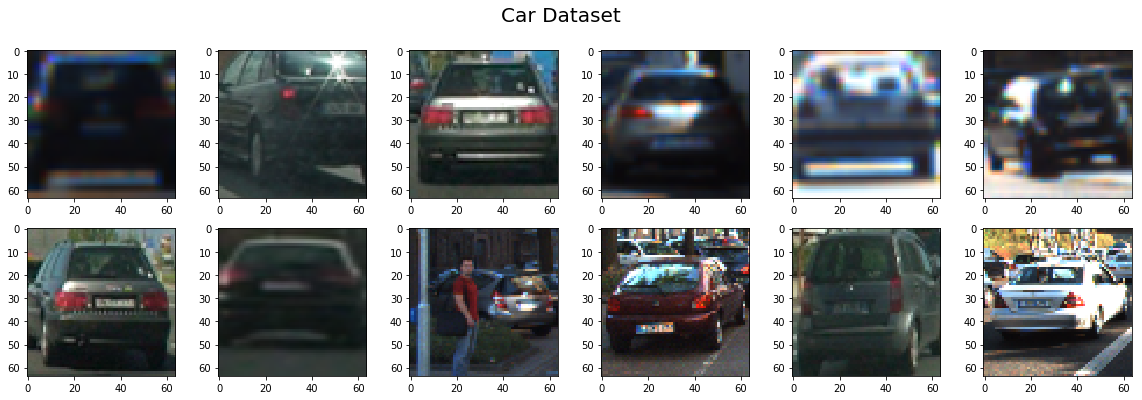

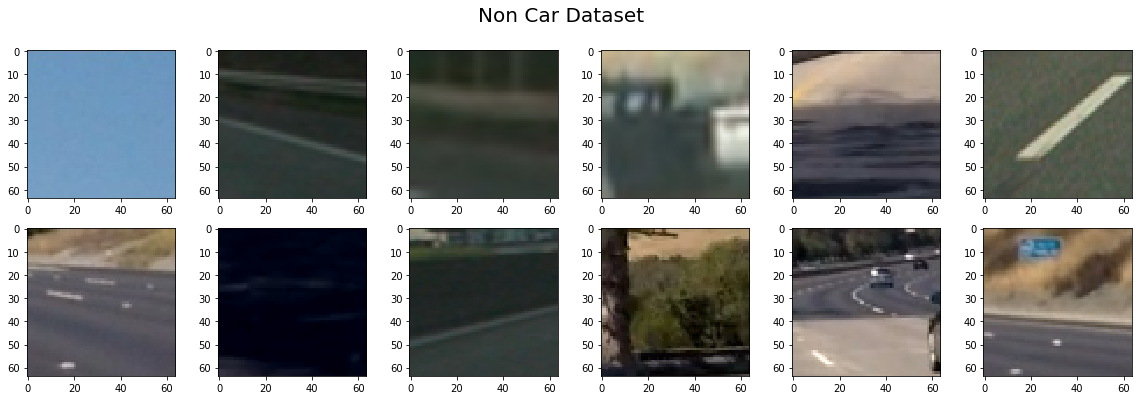

In [2]:
def view_dataset(dataset,
                 title="",
                 figsize=(20, 6)):
    
    data_sample = sample(dataset, 12)
    
    plt.figure(figsize=figsize).suptitle(title, size=20)
    
    for idx, img in enumerate(data_sample):
        plt.subplot(2, 6, idx+1)
        plt.imshow(img)
    plt.show()
    
view_dataset(car_data, title="Car Dataset")
view_dataset(non_car_data, title="Non Car Dataset")

## Useful functions

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


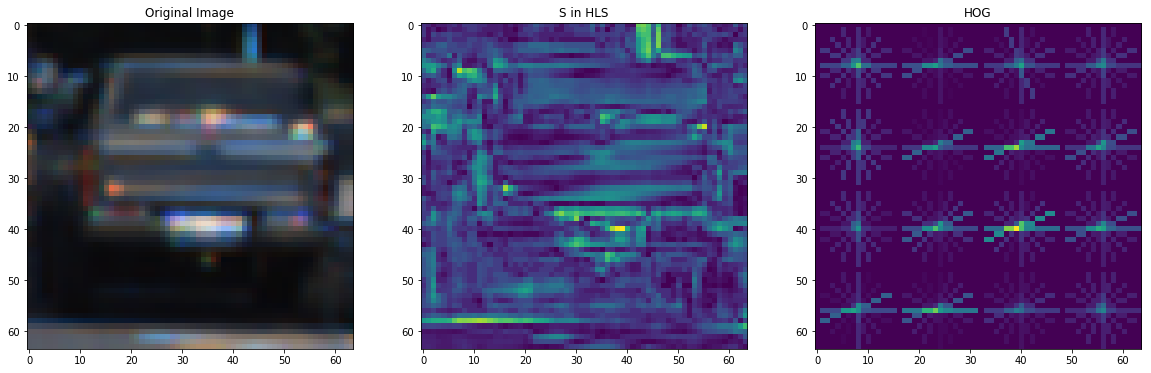

In [3]:
from skimage.feature import hog
import math

conversion = {
    "GRAY": lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2GRAY),
    "HSV": lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HSV),
    "LUV": lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2LUV),
    "HLS": lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HLS),
    "YUV": lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YUV),
    "YCrCb": lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    }

def get_chan(img, chan, color_space="RGB"):
    try:
        return conversion[color_space](img)[:, :, chan]
    except:
        print("Color space does not exist or is not implemented")
        return img[:, :, chan]

def get_hog_features(img, 
                     orient, 
                     pix_per_cell, 
                     cell_per_block, 
                     vis=False, 
                     feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       visualise=False, feature_vector=feature_vec)
        return features

def view_hog_vis():
    some_image_of_a_car = sample(car_data, 1)[0]
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1).set_title("Original Image")
    plt.imshow(some_image_of_a_car)
    plt.subplot(1, 3, 2).set_title("S in HLS")
    s_chan = get_chan(some_image_of_a_car, 2, "HLS")
    plt.imshow(s_chan)
    plt.subplot(1, 3, 3).set_title("HOG")
    ft, vis = get_hog_features(s_chan, 8, 16, 1, vis=True)
    plt.imshow(vis)
    plt.show()
view_hog_vis()

In [4]:
def extract_features(imgs, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2):
    features = []

    for img in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            ft_img = conversion[cspace](img)
        else:
            ft_img = np.copy(img)
        
        spat_img = cv2.resize(ft_img, spatial_size)
        
        hist0 = np.histogram(ft_img[:, :, 0], bins=hist_bins)[0]
        hist1 = np.histogram(ft_img[:, :, 1], bins=hist_bins)[0]
        hist2 = np.histogram(ft_img[:, :, 2], bins=hist_bins)[0]
        spat0 = spat_img[:, :, 0].ravel()
        spat1 = spat_img[:, :, 1].ravel()
        spat2 = spat_img[:, :, 2].ravel()
        hog_ft = []
        hist_ft = np.concatenate((hist0, hist1, hist2))
        spat_ft = np.concatenate((spat0, spat1, spat2))
        
        for chan in range(ft_img.shape[2]):
            hog_ft.append(get_hog_features(ft_img[:, :, chan], 
                                           orient, 
                                           pix_per_cell, 
                                           cell_per_block, 
                                           feature_vec=True))
            
            
        hog_ft = np.ravel(hog_ft)
        
        features.append(np.concatenate((hist_ft, spat_ft, hog_ft)))
    
    return features

## Dataset Splitting and Classifier Training

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

car_ft = extract_features(car_data,
                          cspace="YCrCb",
                          spatial_size=(32, 32),
                          hist_bins=32,
                          orient=9,
                          pix_per_cell=8, 
                          cell_per_block=2)

non_car_ft = extract_features(non_car_data,
                              cspace="YCrCb",
                              spatial_size=(32, 32),
                              hist_bins=32,
                              orient=9,
                              pix_per_cell=8, 
                              cell_per_block=2)

x = [car_ft, non_car_ft]
y = [np.ones(len(car_ft)), np.zeros(len(non_car_ft))]

x = np.vstack(x).astype(np.float64)
y = np.hstack(y)

scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)


rand_state = np.random.randint(0, 100000)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, 
                                                    y, 
                                                    test_size=0.15, 
                                                    random_state=rand_state)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(x_train, y_train)

print("Accuracy on test set: {:.2f} %".format(svm.score(x_test, y_test) * 100))

Accuracy on test set: 99.40 %


## Sliding Window Implementation

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


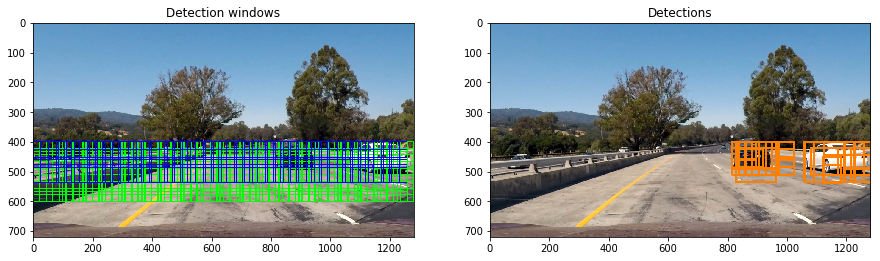

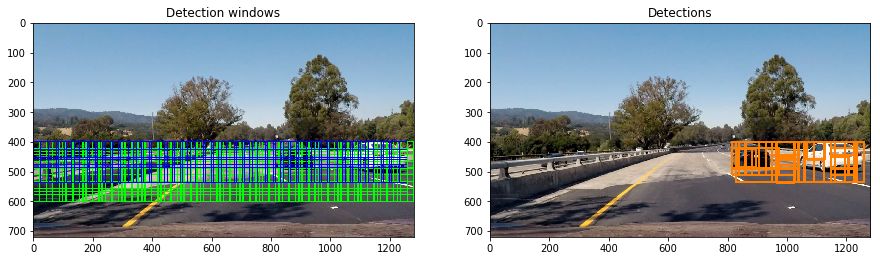

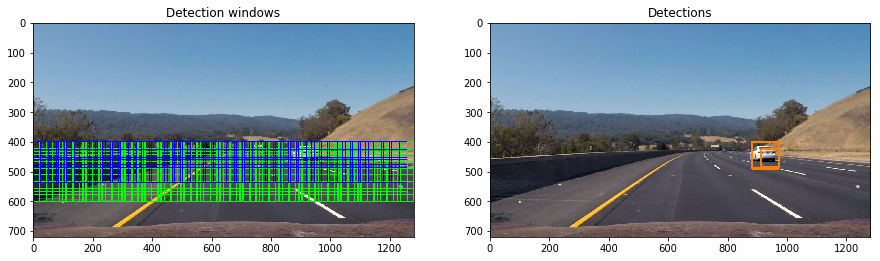

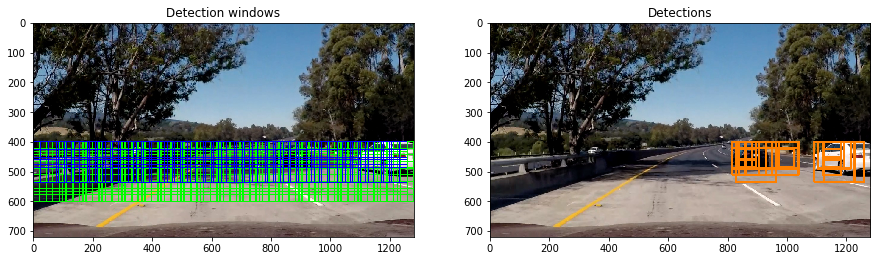

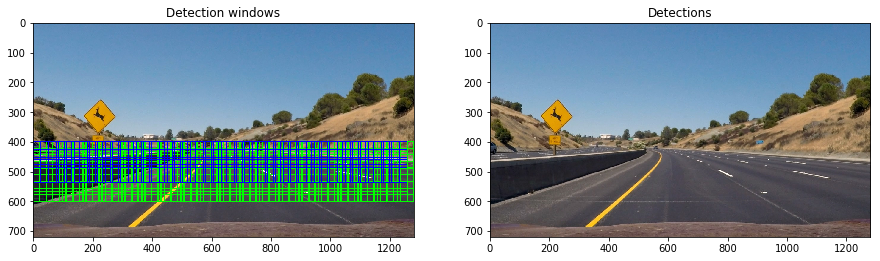

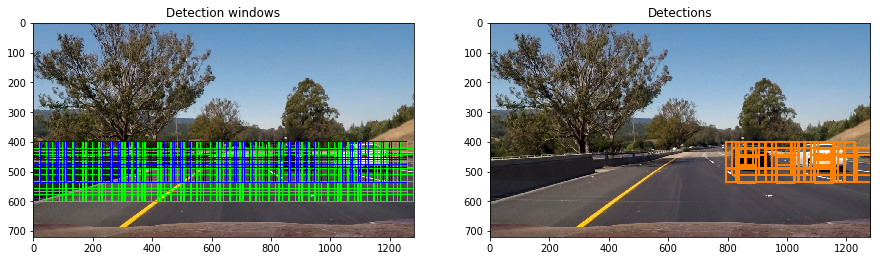

In [7]:
import matplotlib.pyplot as plt
from glob import glob

class WindowBlueprint(object):
    def __init__(self,
                 y_bounds, 
                 size, 
                 overlap):
        self.y_bounds = y_bounds
        self.size = size
        self.overlap = overlap
        self.wins = self.get_window_list()
        
    def get_window_list(self, img_shape=(720, 1280), debug=False):
        x_span = img_shape[1]
        y_span = self.y_bounds[1] - self.y_bounds[0]
        
        x_px_per_step = np.int(self.size[0] * (1 - self.overlap[0]))
        y_px_per_step = np.int(self.size[1] * (1 - self.overlap[1]))
        
        x_buffer = np.int(self.size[0] * self.overlap[0])
        y_buffer = np.int(self.size[1] * self.overlap[1])
        
        x_wins = np.int( (x_span - x_buffer) / x_px_per_step )
        y_wins = np.int( (y_span - y_buffer) / y_px_per_step )
        if debug:
            print("x span ", x_span)
            print("y span ", y_span)
            print("x_px_per_step ", x_px_per_step)
            print("y_px_per_step ", y_px_per_step)
            print("x_buffer ", x_buffer)
            print("y_buffer ", y_buffer)
        
        wins = []
        
        for ys in range(y_wins):
            for xs in range(x_wins):
                x_start = xs * x_px_per_step
                x_end = x_start + self.size[0]
                y_start = ys * y_px_per_step + self.y_bounds[0]
                y_end = y_start + self.size[1]
                wins.append( ((x_start, x_end), 
                              (y_start, y_end)) )
        return wins
    
    def draw_window_boxes_on_image(self, img, color=(0, 0, 0), thick=2):
        for win in self.wins:
            cv2.rectangle(img, 
                          (win[0][0], win[1][0]), 
                          (win[0][1], win[1][1]), color=color, thickness=thick)
        return img
    
    def see_windows(self, img):
        imgs = []
        for win in self.wins:
            test_img = cv2.resize(img[win[1][0]:win[1][1], 
                                      win[0][0]:win[0][1]], (64, 64))
            imgs.append(test_img)
        plt.figure(figsize=(20, 20))
        for idx, img in enumerate(imgs):
            plt.subplot(len(imgs)//4, len(imgs)//4, idx+1)
            plt.imshow(img)
        plt.show()
    
    def get_hot_boxes(self, img, clf):
        hot_wins = []
        for win in self.wins:
            test_img = cv2.resize(img[win[1][0]:win[1][1], 
                                      win[0][0]:win[0][1]], (64, 64))
            ft = extract_features([test_img])
            ft_scaled = scaler.transform(np.array(ft).reshape(1, -1).astype(np.float64))
            prediction = clf.predict(ft_scaled)
            if prediction > 0.99:
                hot_wins.append(win)
        return hot_wins
    
    def draw_rectangle_on_detections(self, img, clf):
        hot_wins = self.get_hot_boxes(img, clf)
        for hot in hot_wins:
            cv2.rectangle(img, 
                          (hot[0][0], hot[1][0]), 
                          (hot[0][1], hot[1][1]), color=(255, 128, 0), thickness=5)
        return img
        

large_window = WindowBlueprint([400, 600], 
                                (135, 135), 
                                (0.75, 0.75))
medium_window = WindowBlueprint([400, 600], 
                                (90, 90), 
                                (0.75, 0.75))

small_window = WindowBlueprint([400, 550], 
                               (60, 60), 
                               (0.55, 0.55))


def test():
    test_imgs = glob("test_images/*.jpg")
    for test_img in test_imgs:
        plt.figure(figsize=(15, 20))
        plt.subplot(1, 2, 1).set_title("Detection windows")
        test_img = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_BGR2RGB)
        test_img2 = test_img.copy()
        
        test_img = large_window.draw_window_boxes_on_image(test_img, color=(0, 255, 0))
        test_img = medium_window.draw_window_boxes_on_image(test_img, color=(0, 255, 0))
        test_img = small_window.draw_window_boxes_on_image(test_img, color=(0, 0, 255))

        plt.imshow(test_img)
        plt.subplot(1, 2, 2).set_title("Detections")
        test_detect = large_window.draw_rectangle_on_detections(test_img2, svm)
        test_detect = medium_window.draw_rectangle_on_detections(test_detect, svm)
        test_detect = small_window.draw_rectangle_on_detections(test_detect, svm)
        plt.imshow(test_detect)
        plt.show()
test()

Using a heatmap for more flexible filtering options

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



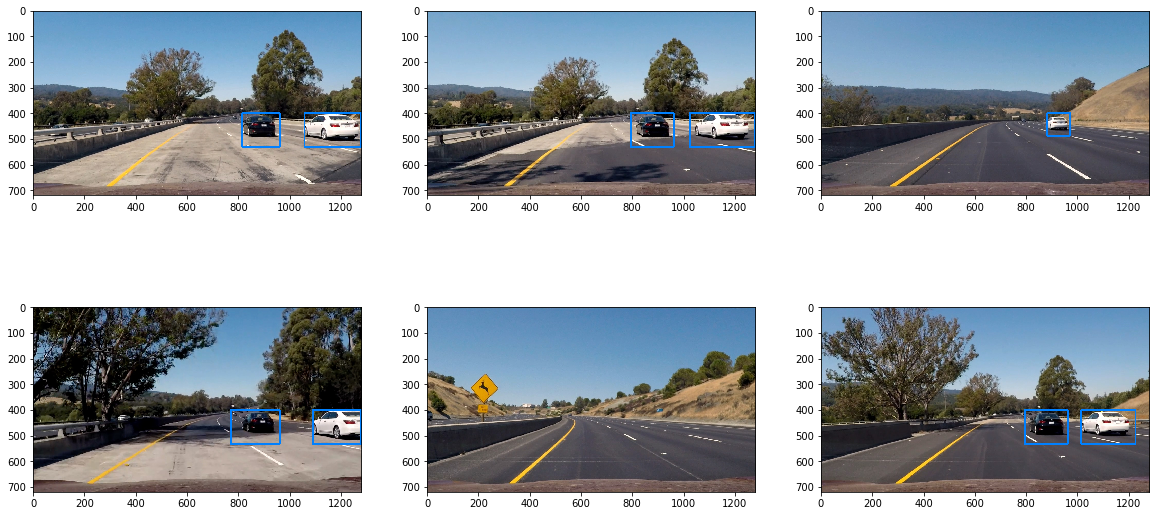

In [19]:
from scipy.ndimage.measurements import label

def heatmap(img, box_list):
    heatmap = np.zeros_like(img[:, :, 0])
    for win_type in box_list:
        for box in win_type:
            heatmap[box[1][0]:box[1][1], box[0][0]:box[0][1]] += 1
    return heatmap


def draw_labeled_boxes(img, labels):
    for n_detection in range(1, labels[1]+1):
        non_zero_y, non_zero_x = (labels[0] == n_detection).nonzero()
        rec = ((np.min(non_zero_x), 
                np.min(non_zero_y)), 
               (np.max(non_zero_x), 
                np.max(non_zero_y)))
        # Draw the box on the image
        cv2.rectangle(img, rec[0], rec[1], (0, 128, 255), 5)
    # Return the image
    return img


def add_heatmap(heatmap, box_list):
    for win_type in box_list:
        for box in win_type:
            heatmap[box[1][0]:box[1][1], box[0][0]:box[0][1]] += 1
    return heatmap

def above(heatmap, thresh):
    heatmap[heatmap < thresh] = 0 
    return heatmap

def test_pipeline():
    test_imgs = glob("test_images/*.jpg")
    plt.figure(figsize=(20, 10))
    for idx, test_path in enumerate(test_imgs):
        plt.subplot(2, len(test_imgs)//2, idx + 1)
        test_img = cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB)
        hot_boxes = []
        hot_boxes.append(large_window.get_hot_boxes(test_img, svm))
        hot_boxes.append(medium_window.get_hot_boxes(test_img, svm))
        hot_boxes.append(small_window.get_hot_boxes(test_img, svm))

        heat = heatmap(test_img, hot_boxes)
        labels = label(heat)
        plt.imshow(draw_labeled_boxes(test_img, labels))
    plt.show()
test_pipeline()

In [9]:
box_stack = []

def pipeline(image):
    hot_boxes = []
    hot_boxes.append(large_window.get_hot_boxes(image, svm))
    hot_boxes.append(medium_window.get_hot_boxes(image, svm))
    hot_boxes.append(small_window.get_hot_boxes(image, svm))
    
    heat = np.zeros_like(image[:, :, 0])
    box_stack.append(hot_boxes)
    for boxes in box_stack:
        heat = add_heatmap(heat, boxes)
    
    heat = above(heat, 20)
    if len(box_stack) > 20:
        box_stack.pop(0)
    
    labels = label(heat)
    return draw_labeled_boxes(image, labels)

In [14]:
from moviepy.editor import VideoFileClip

clip1 = VideoFileClip("project_video.mp4")

clip = clip1.fl_image(pipeline)
%time clip.write_videofile("output_test.mp4", audio=False)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video output_test.mp4
[MoviePy] Writing video output_test.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

100%|█████████▉| 1260/1261 [43:43<00:02,  2.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test.mp4 

CPU times: user 43min 41s, sys: 2.24 s, total: 43min 43s
Wall time: 43min 44s


In [15]:
%%HTML
<video src="output_test.mp4" style="width: 100%" controls />